### GPT Hidden Layer Compression using Fourier Neural Operator (FNO)

The core objective is to replace computationally expensive GPT hidden layers with more efficient FNO-based representations. This implementation:

Captures and analyzes GPT hidden states in response to input tokens
Trains an FNO to reproduce similar hidden states for the same inputs
Enables the trained FNO to be injected back into GPT models


1.	Train a “better” GPT on synthetic non-random DNA-like data (so it learns a pattern).

2.	Capture that GPT’s hidden states.

3.	Train an FNO to replicate those hidden states.

4.	Verify that the MSE between FNO outputs and GPT hidden states actually goes down, rather than staying random.


In [2]:
import os
import re
import math
import random
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
########################################################################
# 1. Generate "Patterned" DNA and Train a GPT Teacher
########################################################################

# -- A) Generate synthetic "patterned" DNA so GPT can learn something meaningful
def generate_patterned_dna(pattern="ATG", length=128):
    """
    Repeats a small pattern until we reach `length`.
    e.g. pattern=ATG =>  ATGATGATG...
    """
    repeats = (length // len(pattern)) + 2
    dna = (pattern * repeats)[:length]
    return dna

def make_patterned_dataset(num_samples=1000, chunk_size=128):
    # E.g. half the time the pattern is "ATG", half the time is "GCC"
    patterns = ["ATG", "GCC"]
    dna_chunks = []
    for _ in range(num_samples):
        pat = random.choice(patterns)
        dna = generate_patterned_dna(pattern=pat, length=chunk_size)
        dna_chunks.append(dna)
    return dna_chunks

# -- B) Build a minimal GPT teacher
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super().__init__()
        self.dropout = nn.Dropout(p=0.0)  # no dropout
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            -torch.arange(0, d_model, 2).float() * (math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :].to(x.device)
        return self.dropout(x)

class DNAGPT_NoValue(nn.Module):
    """
    Small GPT-like model that can return hidden states if needed.
    """
    def __init__(self, vocab_size, embedding_dim=128, nhead=4, num_layers=2, dropout_rate=0.0):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len=1024)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=nhead, batch_first=True, dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.fc_out = nn.Linear(embedding_dim, vocab_size)

    def generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz), diagonal=1).bool()

    def forward(self, src, return_hidden=False):
        """
        If return_hidden=True => (logits, hidden_states).
        hidden_states shape => (batch, seq_len, embedding_dim)
        """
        embeddings = self.token_embedding(src) * math.sqrt(self.embedding_dim)
        embeddings = self.pos_encoder(embeddings)
        src_mask = self.generate_square_subsequent_mask(src.size(1)).to(src.device)

        hidden_states = self.transformer_encoder(embeddings, mask=src_mask)
        logits = self.fc_out(hidden_states)

        if return_hidden:
            return logits, hidden_states
        else:
            return logits

# -- C) Tokenization and Dataset
dna_pattern = re.compile(r"[ATGC]")  # ignoring 'N' for simplicity

def tokenize_dna(seq):
    return dna_pattern.findall(seq.upper())

def build_vocab():
    # We'll define 4 tokens + 1 pad
    tokens = ["A", "C", "G", "T"]
    char_to_index = {t: i+1 for i, t in enumerate(tokens)}  # 1-based
    char_to_index["<pad>"] = 0
    index_to_char = {v: k for k, v in char_to_index.items()}
    return char_to_index, index_to_char

def encode_dna(seq, char_to_index):
    return [char_to_index.get(nt, 0) for nt in seq]

class GPTTrainDataset(Dataset):
    """
    For next-token prediction, input_seq = x[:-1], target_seq = x[1:].
    """
    def __init__(self, dna_list, char_to_index, seq_len):
        self.data = []
        self.seq_len = seq_len
        for dna in dna_list:
            encoded = encode_dna(dna, char_to_index)
            self.data.append(encoded)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.data[idx]
        # We expect exactly seq_len
        input_seq = seq[:-1]   # shape => seq_len-1
        target_seq = seq[1:]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)

def collate_fn_gpt(batch):
    """
    Just stack them. No further padding needed because all are same length.
    """
    inputs = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    inputs = torch.stack(inputs, dim=0)
    targets = torch.stack(targets, dim=0)
    return inputs, targets

# -- D) Train a small GPT
def train_epoch_gpt(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_acc = 0.0, 0.0
    n_samples = 0

    for in_seq, tar_seq in loader:
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        optimizer.zero_grad()
        logits = model(in_seq)  # (batch, seq_len, vocab_size)

        # Flatten
        b, s, v = logits.shape
        loss = criterion(logits.view(-1, v), tar_seq.view(-1))
        loss.backward()
        optimizer.step()

        # Accuracy
        with torch.no_grad():
            preds = logits.argmax(dim=-1)  # (batch, seq_len)
            correct = (preds == tar_seq).sum().item()
            total_acc += correct
            n_samples += (b * s)

        total_loss += loss.item() * b

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_acc / n_samples
    return avg_loss, avg_acc

def eval_epoch_gpt(model, loader, criterion, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    n_samples = 0

    with torch.no_grad():
        for in_seq, tar_seq in loader:
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)

            logits = model(in_seq)
            b, s, v = logits.shape
            loss = criterion(logits.view(-1, v), tar_seq.view(-1))

            preds = logits.argmax(dim=-1)
            correct = (preds == tar_seq).sum().item()
            total_acc += correct
            n_samples += (b * s)

            total_loss += loss.item() * b

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_acc / n_samples
    return avg_loss, avg_acc

def train_gpt_teacher():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[GPT] Using device: {device}")

    # Generate a patterned dataset
    chunk_size = 128
    dna_list = make_patterned_dataset(num_samples=1000, chunk_size=chunk_size)
    random.shuffle(dna_list)
    # 80/20 split
    split_idx = int(0.8 * len(dna_list))
    train_list = dna_list[:split_idx]
    val_list   = dna_list[split_idx:]

    # Build vocab
    char_to_index, index_to_char = build_vocab()
    vocab_size = len(char_to_index)  # 5 = A/C/G/T/<pad>

    # Datasets
    train_ds = GPTTrainDataset(train_list, char_to_index, seq_len=chunk_size)
    val_ds   = GPTTrainDataset(val_list,   char_to_index, seq_len=chunk_size)

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn_gpt)
    val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn_gpt)

    # Create GPT
    model = DNAGPT_NoValue(
        vocab_size=vocab_size,
        embedding_dim=128,
        nhead=4,
        num_layers=2,
        dropout_rate=0.0
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Train GPT
    epochs = 10
    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = train_epoch_gpt(model, train_loader, optimizer, criterion, device)
        va_loss, va_acc = eval_epoch_gpt(model, val_loader, criterion, device)
        print(f"Epoch {epoch:02d} | "
              f"Train Loss={tr_loss:.4f}, Acc={tr_acc:.3f} || "
              f"Val Loss={va_loss:.4f}, Acc={va_acc:.3f}")

    # Save model + vocab
    torch.save(model.state_dict(), "patterned_gpt_model.pth")
    with open("char_to_index.pkl","wb") as f:
        pickle.dump(char_to_index, f)
    with open("index_to_char.pkl","wb") as f:
        pickle.dump(index_to_char, f)

    print("[GPT] Finished training & saved as 'patterned_gpt_model.pth'")
    return model, char_to_index

[GPT] Using device: cpu
Epoch 01 | Train Loss=0.3491, Acc=0.788 || Val Loss=0.2343, Acc=0.837
Epoch 02 | Train Loss=0.2528, Acc=0.827 || Val Loss=0.2337, Acc=0.833
Epoch 03 | Train Loss=0.2482, Acc=0.827 || Val Loss=0.2320, Acc=0.837
Epoch 04 | Train Loss=0.2433, Acc=0.854 || Val Loss=0.2249, Acc=0.992
Epoch 05 | Train Loss=0.2448, Acc=0.843 || Val Loss=0.2259, Acc=0.849
Epoch 06 | Train Loss=0.2893, Acc=0.851 || Val Loss=0.2693, Acc=0.833
Epoch 07 | Train Loss=0.2572, Acc=0.822 || Val Loss=0.2343, Acc=0.833
Epoch 08 | Train Loss=0.2474, Acc=0.822 || Val Loss=0.2324, Acc=0.841
Epoch 09 | Train Loss=0.2462, Acc=0.852 || Val Loss=0.2314, Acc=0.909
Epoch 10 | Train Loss=0.2444, Acc=0.911 || Val Loss=0.2282, Acc=0.924
[GPT] Finished training & saved as 'patterned_gpt_model.pth'
Epoch 01:  Train MSE=1.070598  |  Val MSE=0.750305
Epoch 02:  Train MSE=0.638281  |  Val MSE=0.462609
Epoch 03:  Train MSE=0.394728  |  Val MSE=0.279541
Epoch 04:  Train MSE=0.243580  |  Val MSE=0.185531
Epoch 05:  

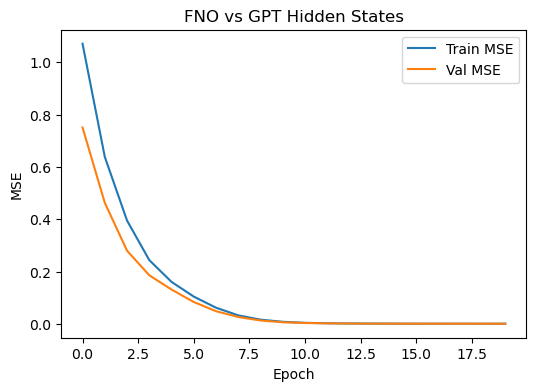

Saved FNO to fno_hidden_compression.pth


In [4]:
########################################################################
# 2. Train an FNO to replicate GPT's hidden states
########################################################################

class ImprovedFourierLayer(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.modes = modes
        self.width = width
        self.scale = 1.0 / (width**2)
        self.weights_real = nn.Parameter(self.scale * torch.randn(modes, width))
        self.weights_imag = nn.Parameter(self.scale * torch.randn(modes, width))
        self.norm = nn.LayerNorm(width)
        self.dropout = nn.Dropout(0.0)  # no dropout

    def forward(self, x):
        # x shape => (batch, width, seq_len)
        residual = x
        x = self.norm(x.transpose(1,2)).transpose(1,2)  # LN on dim=width

        x_ft = torch.fft.rfft(x, dim=-1)
        x_ft = x_ft[:, :, :self.modes]

        out_ft = torch.zeros_like(x_ft, dtype=torch.cfloat)
        out_ft.real = x_ft.real * self.weights_real.unsqueeze(0).transpose(1,2)
        out_ft.imag = x_ft.imag * self.weights_imag.unsqueeze(0).transpose(1,2)

        x_out = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)
        x_out = self.dropout(x_out)
        return x_out + residual

class ImprovedFNO(nn.Module):
    def __init__(self, modes, width, input_dim, output_dim, n_layers=3):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, width)
        self.f_layers = nn.ModuleList([ImprovedFourierLayer(modes, width) for _ in range(n_layers)])
        self.norm_out = nn.LayerNorm(width)
        self.fc_out = nn.Linear(width, output_dim)

    def forward(self, x):
        # x shape => (batch, seq_len, input_dim)
        x = self.fc_in(x)
        x = x.transpose(1, 2)  # => (batch, width, seq_len)
        for layer in self.f_layers:
            x = layer(x)
        x = x.transpose(1, 2)  # => (batch, seq_len, width)
        x = self.norm_out(x)
        x = self.fc_out(x)
        return x

# Dataset that captures GPT hidden states
class GPTHiddenDataset(Dataset):
    def __init__(self, dna_list, char_to_index, gpt_model, seq_len=128, device="cpu"):
        super().__init__()
        self.data = []
        self.gpt_model = gpt_model
        self.device = device

        # Pre-generate (input_one_hot, hidden_states) pairs
        for seq in dna_list:
            encoded = [char_to_index.get(nt, 0) for nt in seq]
            input_tensor = torch.tensor([encoded], dtype=torch.long, device=device)
            with torch.no_grad():
                # get hidden states
                logits, hiddens = gpt_model(input_tensor, return_hidden=True)
            # one-hot
            oh = F.one_hot(input_tensor.squeeze(0), num_classes=len(char_to_index)).float()
            # store
            self.data.append((oh.cpu(), hiddens.squeeze(0).cpu()))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn_fno(batch):
    """
    Each item is (one_hot, hidden_states).
    We stack them across the batch dimension.
    """
    oh_list = []
    hs_list = []
    for oh, hs in batch:
        oh_list.append(oh)
        hs_list.append(hs)
    oh_batch = torch.stack(oh_list, dim=0)  # (B, seq_len, vocab_size)
    hs_batch = torch.stack(hs_list, dim=0) # (B, seq_len, embed_dim)
    return oh_batch, hs_batch

def train_epoch_fno(fno_model, loader, optimizer, device):
    fno_model.train()
    total_loss = 0.0
    criterion = nn.MSELoss()
    n_samples = 0

    for oh, hs in loader:
        oh = oh.to(device)
        hs = hs.to(device)
        optimizer.zero_grad()
        preds = fno_model(oh)
        loss = criterion(preds, hs)
        loss.backward()
        optimizer.step()

        batch_size = oh.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return total_loss / n_samples

@torch.no_grad()
def eval_epoch_fno(fno_model, loader, device):
    fno_model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()
    n_samples = 0

    for oh, hs in loader:
        oh = oh.to(device)
        hs = hs.to(device)
        preds = fno_model(oh)
        loss = criterion(preds, hs)
        batch_size = oh.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return total_loss / n_samples

def main():
    ##############################################
    # 1) Train/Load a GPT on patterned data
    ##############################################
    # If you already trained, just load:
    # teacher_gpt = ...
    # Or re-train quickly:
    teacher_gpt, char_to_index = train_gpt_teacher()

    # Move to device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    teacher_gpt.to(device)
    teacher_gpt.eval()

    # Prepare a small dataset of sequences
    # (the same or different from the GPT's train set)
    chunk_size = 128
    dna_list = make_patterned_dataset(num_samples=200, chunk_size=chunk_size)
    random.shuffle(dna_list)
    split_idx = int(0.8 * len(dna_list))
    train_list = dna_list[:split_idx]
    val_list   = dna_list[split_idx:]

    # Build FNO datasets
    train_fno_ds = GPTHiddenDataset(train_list, char_to_index, teacher_gpt, seq_len=chunk_size, device=device)
    val_fno_ds   = GPTHiddenDataset(val_list,   char_to_index, teacher_gpt, seq_len=chunk_size, device=device)

    train_loader = DataLoader(train_fno_ds, batch_size=8, shuffle=True, collate_fn=collate_fn_fno)
    val_loader   = DataLoader(val_fno_ds,   batch_size=8, shuffle=False, collate_fn=collate_fn_fno)

    # teacher GPT's embedding_dim=128 (from code above)
    embed_dim = 128

    ##############################################
    # 2) Define FNO to replicate GPT hidden states
    ##############################################
    fno_model = ImprovedFNO(
        modes=12,
        width=48,
        input_dim=len(char_to_index),  # one-hot input
        output_dim=embed_dim,
        n_layers=3
    ).to(device)

    optimizer = optim.AdamW(fno_model.parameters(), lr=1e-3)

    ##############################################
    # 3) Train the FNO
    ##############################################
    epochs = 20
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs+1):
        tr_loss = train_epoch_fno(fno_model, train_loader, optimizer, device)
        va_loss = eval_epoch_fno(fno_model, val_loader, device)
        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        print(f"Epoch {epoch:02d}:  Train MSE={tr_loss:.6f}  |  Val MSE={va_loss:.6f}")

    ##############################################
    # 4) Plot
    ##############################################
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train MSE')
    plt.plot(val_losses, label='Val MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('FNO vs GPT Hidden States')
    plt.legend()
    plt.show()

    # Save FNO
    torch.save(fno_model.state_dict(), "fno_hidden_compression.pth")
    print("Saved FNO to fno_hidden_compression.pth")


if __name__ == "__main__":
    main()